In [1]:
# load all the necessary packages
import pandas as pd
import numpy as np
import math
import nltk
import matplotlib.pylab as plt
import sklearn               
import seaborn as sns

In [2]:
# unpickle the cleaned data
import pickle
fname = open('../data_full/ted_clean.pkl', 'rb')
ted_clean = pickle.load(fname)
fname.close()

In [3]:
# check if I did correctly
ted_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          957 non-null    object 
 1   comments       957 non-null    int64  
 2   transcript     957 non-null    object 
 3   tok_low        957 non-null    object 
 4   kband_ave      957 non-null    float64
 5   ratings_tuple  957 non-null    object 
 6   pos_neg        957 non-null    object 
 7   label          957 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 59.9+ KB


## 1. Textual feature -- Label Classification

### Multinomial NB

* Why multinomial NB?  
    - cause it's fast and efficient

In [4]:
# load packages needed
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [5]:
# split the data into train set and test set
trans_train, trans_test, label_train, label_test = train_test_split(ted_clean.transcript, ted_clean.label, 
                                                                    test_size=0.2, random_state=0)

In [6]:
NBmodel = make_pipeline(TfidfVectorizer(max_features=1500, stop_words='english'),
                        MultinomialNB())
NBmodel.fit(trans_train, label_train)


accuracy_score(label_test, NBmodel.predict(trans_test))

0.6927083333333334

In [7]:
# check the performance of the model with confusion matrix
label_pred = NBmodel.predict(trans_test)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(label_test, label_pred)  # label_test (arg1) = y axis, label_pred (arg2) = x axis
print(mat)

[[  0  58]
 [  1 133]]


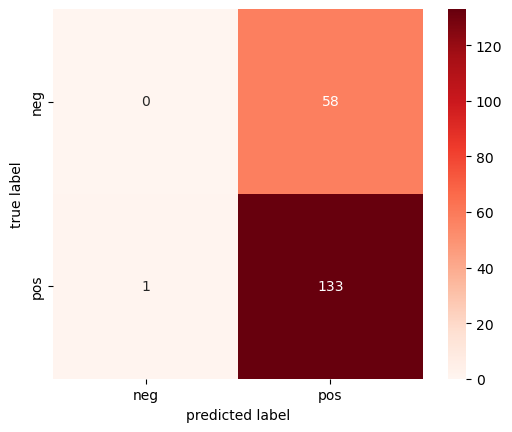

In [8]:
# make a heatmap
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds",
xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
# fmt: either 's' or 'd'; s = string, d = decimal
# square: the shape of each cell
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [9]:
# change the max_feature to 3000
NBmodel = make_pipeline(TfidfVectorizer(max_features=3000, stop_words='english'),
                        MultinomialNB())
NBmodel.fit(trans_train, label_train)


accuracy_score(label_test, NBmodel.predict(trans_test))

0.703125

* Very slight increase.. 

In [10]:
# make a confusion_matrix to make a heatmap
label_pred = NBmodel.predict(trans_test)
mat = confusion_matrix(label_test, label_pred)  # label_test (arg1) = y axis, label_pred (arg2) = x axis
print(mat)

[[  1  57]
 [  0 134]]


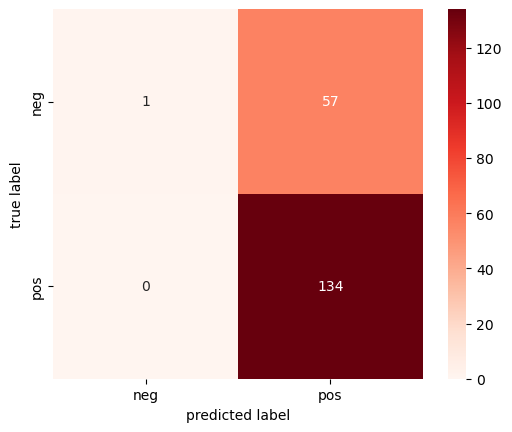

In [11]:
# make a heatmap
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds",
xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

* Regardless of the number of feature, the model labeled almost all the transcripts as positive.
* What was the key feature for the model to label those true negative transcripts as negative?  
Is there a way to figure this out?  
* then how about 5000 features?

In [12]:
# change max_feature to 5000 to see if there is any difference
NBmodel = make_pipeline(TfidfVectorizer(max_features=5000, stop_words='english'),
                        MultinomialNB())
NBmodel.fit(trans_train, label_train)


accuracy_score(label_test, NBmodel.predict(trans_test))

0.6979166666666666

* ohh it decreased even more than that of 1500 features?!

In [13]:
# make a confusion_matrix to make a heatmap
label_pred = NBmodel.predict(trans_test)
mat = confusion_matrix(label_test, label_pred)  # label_test (arg1) = y axis, label_pred (arg2) = x axis
print(mat)

[[  0  58]
 [  0 134]]


* Seems like after increasing the max feature to 5000, the model shows overfitting.

* Here, we can conclude that according to NB model, it is not possible to predict the rate of positive review of the talks solely by the transcripts.

### SVM

* Why SVM?  
    - Cause I am trying to predict the categorical variable, and SVM is pretty much for the exact purpose. (Also wanted to adopt a model little more complicated than NB model.)

In [75]:
# calcualte tf-idf before applying the raw data into svm
vectorz = TfidfVectorizer(max_df=0.5, min_df=2, max_features=1500, stop_words='english')

tf_train = vectorz.fit_transform(trans_train)
tf_test = vectorz.transform(trans_test)

In [76]:
# Build svm, with (quite a) hard margin
svcmdl = SVC(kernel='linear', C=1E5)
svcmdl.fit(tf_train, label_train)

SVC(C=100000.0, kernel='linear')

In [77]:
# Check the accuracy
accuracy_score(label_test, svcmdl.predict(tf_test))

0.59375

In [78]:
# make a confusion_matrix to make a heatmap
label_pred = svcmdl.predict(tf_test)
mat = confusion_matrix(label_test, label_pred)  # label_test (arg1) = y axis, label_pred (arg2) = x axis
print(mat)

[[27 37]
 [41 87]]


* Interesting! Even though the accuracy is low, SVM model correctly labels the true negative reviews.

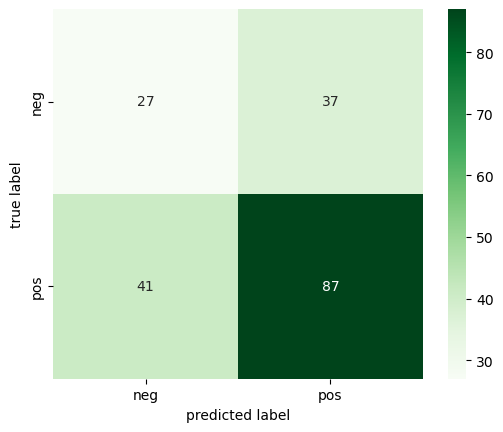

In [79]:
# make a heatmap
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Greens",
xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [80]:
# # Build another SVM, with softer margin and check the performance
svcmdl_soft = SVC(kernel='linear', C=1E2)
svcmdl_soft.fit(tf_train, label_train)
accuracy_score(label_test, svcmdl_soft.predict(tf_test))

0.59375

* Exactly the same performance with hard margin (C=1E5)
* Let's try with softer margin

In [81]:
# Build another SVM, with EVEN softer margin and check the performance
svcmdl_softer = SVC(kernel='linear', C=1)
svcmdl_softer.fit(tf_train, label_train)
accuracy_score(label_test, svcmdl_softer.predict(tf_test))

0.6927083333333334

* the softer the margin, the higher the accuracy
* Let's check how each model did on the true negative transcripts

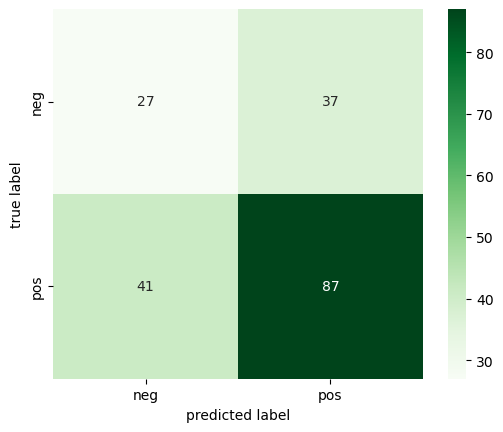

In [82]:
# a heatmap with soft-margin SVM
label_pred = svcmdl_soft.predict(tf_test)
mat = confusion_matrix(label_test, label_pred) 

sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Greens",
xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

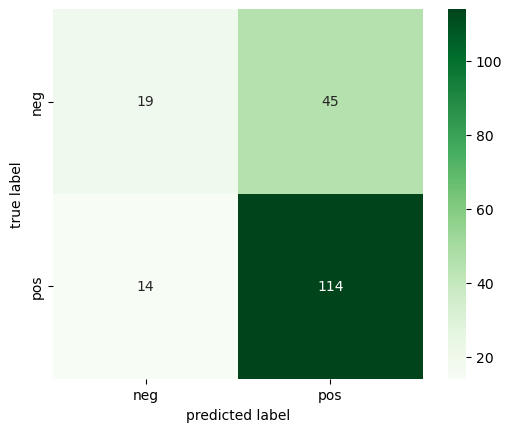

In [83]:
# a heatmap with EVEN soft-margin SVM
label_pred = svcmdl_softer.predict(tf_test)
mat = confusion_matrix(label_test, label_pred) 

sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Greens",
xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

* As the margin becomes softer, the percentage that SVM labels transcript as positive rises. I compared the right columns of each heatmap.

* Should I try clustering? What features played an important role? What should I do more to get to know the internal work of this?

#### Let's try other linguistic features

### Multinomial NB

In [84]:
# split the data into train set and test set
trans_train, trans_test, label_train, label_test = train_test_split(ted_clean.transcript, ted_clean.label, 
                                                                    test_size=0.2, random_state=10)

In [85]:
# Make NB model with bigram feature
NBmodel = make_pipeline(TfidfVectorizer(max_features=20000, ngram_range=(1, 2)),
                        MultinomialNB())
NBmodel.fit(trans_train, label_train)


accuracy_score(label_test, NBmodel.predict(trans_test))

0.6666666666666666

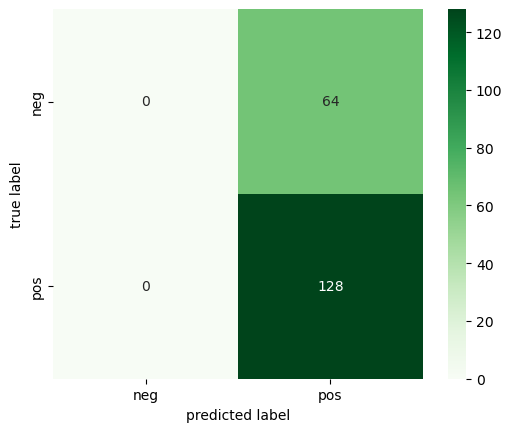

In [86]:
# a heatmap with bigram NB model
label_pred = NBmodel.predict(trans_test)
mat = confusion_matrix(label_test, label_pred) 

sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds",
xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

* Bigram model labeled them all as positive - less sophisticated than unigram model.

### SVM

* I will try bigram and trigram features for SVM model.

In [124]:
# make svm with ngram feature and train it
ngram_svm = make_pipeline(TfidfVectorizer(max_features=15000, ngram_range=(2,3)), 
                         SVC(kernel='linear', C=1, random_state=0))

ngram_svm.fit(trans_train, label_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=15000, ngram_range=(2, 3))),
                ('svc', SVC(C=1, kernel='linear', random_state=0))])

In [125]:
# Check the accuracy
accuracy_score(label_test, ngram_svm.predict(trans_test))

0.6666666666666666

In [126]:
# make a confusion_matrix to make a heatmap
label_pred = ngram_svm.predict(trans_test)
mat = confusion_matrix(label_test, label_pred)  # label_test (arg1) = y axis, label_pred (arg2) = x axis
print(mat)

[[  6  58]
 [  6 122]]


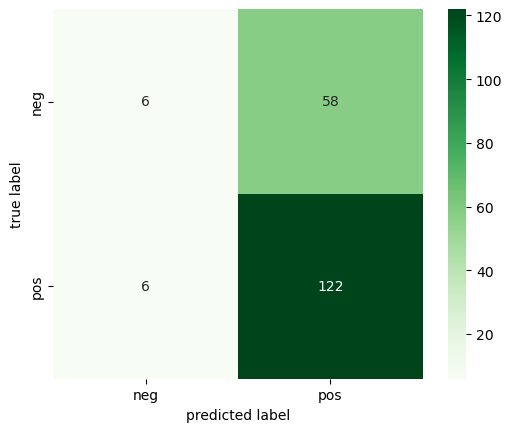

In [127]:
# make a heatmap
sns.heatmap(mat, square=True, annot=True, cmap="Greens", fmt='d',
xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

* Model built based on bigram feature does slightly better than unigram model, but we can conclude that there is no significant difference in performance because it still is below the base line (67%).

## 2. K-band & `obnoxious`

### Feature Enginieering Part

* Sub-hypothesis to check: the higher the k-band is, the higher the percentage of the rating `obnoxious`

In [130]:
# make a toy data set 
toy_df = ted_clean.head(10)

In [144]:
# build a function to calculate the percentage of the rating `obnoxious`
def obs_cal(data):
    total = sum([int(j) for (i, j) in data])
    obs_score = sum([int(j) for (i, j) in data if i == 'Obnoxious'])
    return (obs_score)*100/total

In [147]:
# check if it works
toy_df.ratings_tuple.map(obs_cal)

0    0.222696
1    4.461853
2    5.028329
3    0.938841
4    0.238095
5    2.181558
6    4.834945
7    0.488281
8    2.103396
9    4.455386
Name: ratings_tuple, dtype: float64

In [153]:
# make another column of the percentage of rating `obnoxious`
ted_clean['obs_perc'] = ted_clean.ratings_tuple.map(obs_cal)

In [157]:
# look at the data form
ted_clean.obs_perc.describe()

count    957.000000
mean       1.523199
std        2.328065
min        0.000000
25%        0.367366
50%        0.844206
75%        1.746324
max       36.014819
Name: obs_perc, dtype: float64

In [128]:
# Change the set_option of pandas to see the whole transcript
pd.set_option('display.max_colwidth', 2000)

In [98]:
# Check the transcript with the highest obnoxious percentage
pd.DataFrame(ted_clean[ted_clean.obs_perc == max(ted_clean.obs_perc)]['transcript'])

,transcript
361,"I'll start with my favorite muse, Emily Dickinson, who said that wonder is not knowledge, neither is it ignorance. It's something which is suspended between what we believe we can be, and a tradition we may have forgotten. And I think, when I listen to these incredible people here, I've been so inspired — so many incredible ideas, so many visions. And yet, when I look at the environment outside, you see how resistant architecture is to change. You see how resistant it is to those very ideas. We can think them out. We can create incredible things. And yet, at the end, it's so hard to change a wall. We applaud the well-mannered box. But to create a space that never existed is what interests me; to create something that has never been, a space that we have never entered except in our minds and our spirits. And I think that's really what architecture is based on.Architecture is not based on concrete and steel and the elements of the soil. It's based on wonder. And that wonder is really what has created the greatest cities, the greatest spaces that we have had. And I think that is indeed what architecture is. It is a story. By the way, it is a story that is told through its hard materials. But it is a story of effort and struggle against improbabilities. If you think of the great buildings, of the cathedrals, of the temples, of the pyramids, of pagodas, of cities in India and beyond, you think of how incredible this is that that was realized not by some abstract idea, but by people.So, anything that has been made can be unmade. Anything that has been made can be made better. There it is: the things that I really believe are of important architecture. These are the dimensions that I like to work with. It's something very personal. It's not, perhaps, the dimensions appreciated by art critics or architecture critics or city planners. But I think these are the necessary oxygen for us to live in buildings, to live in cities, to connect ourselves in a social space.And I th..."


### Regression

In [99]:
# split the data set into train and test set
kband_train, kband_test, obs_train, obs_test = train_test_split(ted_clean[['kband_ave']], ted_clean.obs_perc,
                                                                test_size = 1/5, random_state=0)

In [100]:
# import linear regression and run the model
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(kband_train, obs_train)

LinearRegression()

In [101]:
# calculate the coefficient; the strength of the correlation
regressor.coef_

array([0.1122869])

* Low correlation between k-band and the rating `obnoxious`

In [102]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(obs_test, regressor.predict(kband_test))

1.241665956367778

* On average, this regression model is off by 1.24 point.

## 3. Sentence length and `longwinded`

* ANOTHER sub-hypothesis: what about the sentence length and the rating `longwinded`?

### Feature Enginieering Part

In [158]:
# make another column for the ratio of `long-winded`
def long_cal(data):
    total = sum([int(j) for (i, j) in data])
    long_score = sum([int(j) for (i, j) in data if i == 'Longwinded'])
    return (long_score)*100/total

In [159]:
# insert the list into the data frame and check
ted_clean['long_perc'] = ted_clean.ratings_tuple.map(long_cal)

In [160]:
pd.set_option('display.max_colwidth', 50)
ted_clean.head(4)

,title,comments,transcript,tok_low,kband_ave,ratings_tuple,pos_neg,label,obs_perc,long_perc,sent_len
0,Do schools kill creativity?,4553,Good morning. How are you?(Laughter)It's been ...,"[good, morning, ., how, are, you, ?, (, laught...",2.712990,"((Funny, 19645), (Beautiful, 4573), (Ingenious...","(98.7721, 1.2279)",pos,0.222696,0.412360,247
1,Averting the climate crisis,265,"Thank you so much, Chris. And it's truly a gre...","[thank, you, so, much, ,, chris, ., and, it, '...",2.777508,"((Funny, 544), (Courageous, 139), (Confusing, ...","(79.3633, 20.6367)",neg,4.461853,3.848774,134
2,Simplicity sells,124,"(Music: ""The Sound of Silence,"" Simon & Garfun...","[(, music, :, ``, the, sound, of, silence, ,, ...",2.750460,"((Funny, 964), (Courageous, 45), (Ingenious, 1...","(86.8932, 13.1068)",neg,5.028329,2.762040,274
3,Greening the ghetto,200,If you're here today — and I'm very happy that...,"[if, you, 're, here, today, —, and, i, 'm, ver...",3.192360,"((Courageous, 760), (Beautiful, 291), (Confusi...","(95.7178, 4.2822)",pos,0.938841,1.421674,167


In [161]:
# check how the column looks like
ted_clean.long_perc.describe()

count    957.000000
mean       2.101035
std        2.823537
min        0.000000
25%        0.513978
50%        1.152580
75%        2.548853
max       25.324675
Name: long_perc, dtype: float64

In [105]:
# calculate the sentence length of each talk
ted_clean['sent_len'] = ted_clean.transcript.map(lambda x: len(nltk.sent_tokenize(x)))

In [129]:
# Short excerpt of the talk with the highest longwinded percentage
pd.set_option('display.max_colwidth', 1000)
pd.DataFrame(ted_clean[ted_clean.long_perc == max(ted_clean.long_perc)].transcript)

,transcript
318,"When I was five years old I fell in love with airplanes. Now I'm talking about the '30s. In the '30s an airplane had two wings and a round motor, and was always flown by a guy who looked like Cary Grant. He had high leather boots, jodhpurs, an old leather jacket, a wonderful helmet and those marvelous goggles — and, inevitably, a white scarf, to flow in the wind. He'd always walk up to his airplane in a kind of saunter, devil-may-care saunter, flick the cigarette away, grab the girl waiting here, give her a kiss. (Laughter) And then mount his airplane, maybe for the last time. Of course I always wondered what would happen if he'd kissed the airplane first. (Laughter)But this was real romance to me. Everything about flying in those years, which was — you have to stop and think for a moment — was probably the most advanced technological thing going on at the time. So as a youngster, I tried to get close to this by drawing airplanes, constantly drawing airplanes. It's the way I got a part of this romance. And of course, in a way, when I say romance, I mean in part the aesthetics of that whole situation. I think the word is the holistic experience revolving around a product. The product was that airplane. But it built a romance. Even the parts of the airplane had French names. Ze fuselage, ze empanage, ze nessal. You know, from a romance language. So that it was something that just got into your spirit. It did mine.And I decided I had to get closer than just drawing fantasy airplanes. I wanted to build airplanes. So I built model airplanes. And I found that in doing the model airplanes the appearance drawings were not enough. You couldn't transfer those to the model itself. If you wanted it to fly you had to learn the discipline of flying. You had to learn about aeronautics. You had to learn what made an airplane stay in the air. And of course, as a model in those years, you couldn't control it. So it had to be self-righting, and stay up without crashing. So I had t..."


### Regression

In [107]:
# split the data set into train and test data
sent_train, sent_test, long_train, long_test = train_test_split(ted_clean[['sent_len']], ted_clean.long_perc,
                                                                test_size=0.2, random_state=2)

In [108]:
# run the linear regression
regressor = LinearRegression()
regressor.fit(sent_train, long_train)

LinearRegression()

In [109]:
# calculate the coefficient; the strength of the correlation
regressor.coef_

array([0.00919571])

* Very very low.. so, there is no correlation between the sentence length of the talk and the possibility of getting rated as `longwinded`